# Facial Detection and Data Generation

In [1]:
# import the necessary packages
import numpy as np
import cv2
from combine import deep_convert
from webimg import url_to_image

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
#image3 = "https://s1.gossipcop.com/up/2018/12/Katie-Holmes-Jamie-Foxx-Tom-Cruise-Meeting-762x395.jpg"
#image = "https://pnimg.net/lrep/1941/21/bfa9d699389.jpg" # 3 faces
#image = "https://cdn.pixabay.com/photo/2017/11/19/07/30/girl-2961959_960_720.jpg"
#image = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0e/Humberto_Brenes.jpg/220px-Humberto_Brenes.jpg"
#image = "http://farm8.staticflickr.com/7318/9552095411_9c3ce88a8e.jpg"
#image1 = "https://i.ytimg.com/vi/T0sCowo5Zvc/maxresdefault.jpg" #1280*720
#image = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT_kxfvnWvIMrezky3QAO0duDdoE1gg2guNqeC-9jRqgm1e-G6u" #1280 * 800
image = "https://amp.businessinsider.com/images/545d246c6da8117968f5a005-750-562.jpg" #750 * 562

In [4]:
# image = "/Users/erikni/Downloads/New Training Data as of 10052018/30251 Sad.png"

In [5]:
def convert_single_img(input_img):
    try:
        temp_outs = deep_convert(input_img, pic_id = 0, return_rectangle = True, save_img=False)
        
        for temp_out in temp_outs[1]:
            width = temp_out[1] - temp_out[0]
            height = temp_out[3] - temp_out[2]
            temp_out[0] += round(width * 0.12)
            temp_out[1] -= round(width * 0.12)
            temp_out[2] += round(height * 0.12)
            temp_out[3] -= round(height * 0.12)
        
    except:
        print("fail to find the front face")
        
    return temp_outs

In [6]:
def image_shown(image):
    """
    CV2 package use BGR, matplotlib use RGB
    """
    try:
        temp_out = convert_single_img(image)
    except:
        None
    img = url_to_image(image)
    height, width, channels = img.shape
    green = (0, 255, 0)
    face_num = 0
    for temp in temp_out[1]:
        left, right, up, down = temp[0:4]
        line_thick = round(height/120)
        cv2.rectangle(img, (left, up), (right, down), green, thickness=line_thick)
        face_num += 1
        cv2.putText(img, "Person" + str(face_num), (left, up - 4*line_thick),
                cv2.FONT_HERSHEY_SIMPLEX, line_thick/4, (0, 255, 0), 2)
    cv2.imwrite("outputimage.jpg", img)
    img=mpimg.imread("outputimage.jpg")
    plt.imshow(img)
    print(line_thick)

5


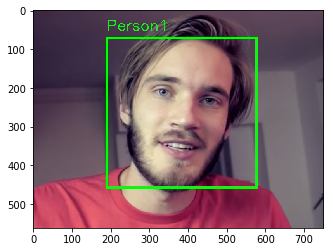

In [8]:
image_shown(image)


In [10]:
test_img_data = convert_single_img(image)[0]
print(test_img_data)

[array([58, 59, 59, ..., 91, 92, 93], dtype=uint8)]


In [11]:
# convert np data type into int data type for json

push_data = []
for single_img_data in test_img_data:
    temp = single_img_data.reshape(200,200)/255.
    single_push_data = []
    for i in temp:
        row = []
        for j in i:
            row.append([j])
        single_push_data.append(row)
    push_data.append(single_push_data)    
"""
for i in test_img_data:
    push_data.append(int(i))
"""


'\nfor i in test_img_data:\n    push_data.append(int(i))\n'

In [12]:
push_data_np = np.array(push_data)

In [13]:
# need a 1*200*200*1 input
push_data_np.shape

(1, 200, 200, 1)

# Use Rest API to Get Prediction

In [15]:
import requests
import json

In [19]:
labels = ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [20]:
# convert data into json
posted={}

for i in range(len(push_data)):

    data = {"instances":[push_data[i]]}

    push_data_json = json.dumps(data, sort_keys=True, separators=(',', ': '))

    """
    with open('data.json', 'w') as outfile:
        json.dump(push_data_json, outfile)
    """
    #print(push_data_json)
    
    r1 = requests.post("http://35.224.178.33:8501/v1/models/model1:predict", data=push_data_json)
    r2 = requests.post("http://35.224.178.33:8501/v1/models/model2:predict", data=push_data_json)
    r3 = requests.post("http://35.224.178.33:8501/v1/models/model3:predict", data=push_data_json)
    r4 = requests.post("http://35.224.178.33:8501/v1/models/model4:predict", data=push_data_json)
    r5 = requests.post("http://35.224.178.33:8501/v1/models/model5:predict", data=push_data_json)
    prediction_1 = json.loads(r1.text)['predictions'][0]
    prediction_2 = json.loads(r2.text)['predictions'][0]
    prediction_3 = json.loads(r3.text)['predictions'][0]
    prediction_4 = json.loads(r4.text)['predictions'][0]
    prediction_5 = json.loads(r5.text)['predictions'][0]
    ensemble_prob = np.average([prediction_1, prediction_2, prediction_3, prediction_4, prediction_5], axis = 0).round(4)    
    locals()['res' + str(i)] = dict([[x,  "{:4.4f}".format(y)] for x, y in zip(labels, ensemble_prob.tolist())])
    posted['res' + str(i)] = locals()['res' + str(i)]

In [21]:
posted['number'] = len(push_data) -1
print(posted)
helper ={}
helper['posted'] = posted


{'res0': {'Anger': '0.1308', 'Contempt': '0.2612', 'Disgust': '0.3025', 'Fear': '0.0271', 'Happy': '0.0127', 'Neutral': '0.0669', 'Sad': '0.1536', 'Surprise': '0.0453'}, 'number': 0}
